# Bejing Air Quality Training

In [ ]:
import os
import glob
import numpy as np # linear algebra
import random
import json
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, optimizers, metrics
from tensorflow.keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import regularizers
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

In [ ]:
SEQUENCE_LEN = 5
BATCH_SIZE = 128
PM_25_BOUNDARIES = [35, 75, 150]
NUM_CLASSES = len(PM_25_BOUNDARIES) + 1
NUM_COLS = 16
batch_size = BATCH_SIZE

# PM2.5 categorisation project

This project looks at the weather recording stations data around Beijing it then uses various machine learning methods to predict PM2.5 concentrations, this notebook is the *training* notebook.

it does this by classifying them into four categories:

<=35

36-75

76-150

,>151



Datasets:

The normalised data was batched and windowed, then PCA batched data was created. The regular data was then extracted to numpy data there was a 70-20-10 split of training, validation and test data.

Models:

lstm_base: the baseline lstm model

lstm_pca: a lstm model with pca

lstm_deep: a deeper model with dropout layers

rfp: a regular randomforest with default parameters

rfh: random_forest with changed hyper-paramters

lstm_final: a lstm with three performance investigations on the test data

In [ ]:
# Load the dataset
base_dir = '/datasets/beijing-air/normalised'

In [ ]:
datafiles = glob.glob(base_dir + '/*.csv')
datafiles

['/datasets/beijing-air/normalised/PRSA_Data_Gucheng_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Dongsi_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Aotizhongxin_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Nongzhanguan_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Wanshouxigong_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Wanliu_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Dingling_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Changping_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Tiantan_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Shunyi_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Guanyuan_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Huairou_20130301-20170228.csv']

In [ ]:
train_datafiles = datafiles[:7]
validation_datafiles = datafiles[7:9]
test_datafiles = datafiles[9:]
train_datafiles, validation_datafiles, test_datafiles

(['/datasets/beijing-air/normalised/PRSA_Data_Gucheng_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Dongsi_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Aotizhongxin_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Nongzhanguan_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Wanshouxigong_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Wanliu_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Dingling_20130301-20170228.csv'],
 ['/datasets/beijing-air/normalised/PRSA_Data_Changping_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Tiantan_20130301-20170228.csv'],
 ['/datasets/beijing-air/normalised/PRSA_Data_Shunyi_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Guanyuan_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Huairou_20130301-20170228.csv'])

# load and chain *no* pca

In [ ]:
def load_and_chain_ds(filenames):
    base_ds = tf.data.experimental.make_csv_dataset(
        filenames[0],
        batch_size=BATCH_SIZE,
        label_name='PM2.5',
        shuffle=False, num_epochs=1,
        )
    for f in filenames[1:]:
        d = tf.data.experimental.make_csv_dataset(
            f,
            batch_size=BATCH_SIZE,
            label_name='PM2.5',
            shuffle=False, num_epochs=1,
            )
        base_ds = base_ds.concatenate(d)
    base_ds = base_ds.cache()
    base_ds = base_ds.prefetch(tf.data.AUTOTUNE)
    return base_ds

In [ ]:
train_ds = load_and_chain_ds(train_datafiles)
validation_ds = load_and_chain_ds(validation_datafiles)
test_ds = load_and_chain_ds(test_datafiles)

In [ ]:
train_ds

<PrefetchDataset element_spec=(OrderedDict([('PM10', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('SO2', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('NO2', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('CO', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('O3', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('TEMP', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('PRES', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('DEWP', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('RAIN', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('station', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('day_sin', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('day_cos', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('year_sin', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('year_cos', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('wind_x', TensorSpec

# massage input no pca

In [ ]:
pm25_categories = Discretization(bin_boundaries=PM_25_BOUNDARIES, output_mode='one_hot')

@tf.function
def merge_cols(x):
    inputs = tf.convert_to_tensor(list(x.values()))
    return tf.transpose(inputs)

In [ ]:
train_ds = train_ds.map(lambda x, y: (
    merge_cols(x), pm25_categories(y)))

validation_ds = validation_ds.map(lambda x, y: (
    merge_cols(x), pm25_categories(y)))

test_ds = test_ds.map(lambda x, y: (
    merge_cols(x), pm25_categories(y)))

test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# Extract x, y function

In [ ]:
def extract_features(dataset):
    """
    Extracts features and target labels from a batched dataset and then converts them to NumPy arrays

    Parameters:
        dataset (tf.data.Dataset) - A batched dataset.

    Returns:
        tuple: A tuple (X, y) X being the features and y being the labels
    """
    X_ds = dataset.map(lambda x, y: x)
    y_ds = dataset.map(lambda x, y: y)
    X = next(iter(X_ds))
    y = next(iter(y_ds))
    X = np.concatenate(list(X_ds.as_numpy_iterator()))    #this converts my data to a numpy X_train, y_train etc.. for rf
    y = np.concatenate(list(y_ds.as_numpy_iterator()))
    return X, y

## Create time-based windows of data

In [ ]:
def windowify(dataset, window_size=SEQUENCE_LEN, batch_size=BATCH_SIZE):
    fds = dataset.unbatch().window(window_size, shift=1)
    fds_x = fds.flat_map(
        lambda x, y: x.batch(window_size, drop_remainder=True))
    fds_y = fds.flat_map(
        lambda x, y: y.batch(window_size, drop_remainder=True))
    fds_y = fds_y.map(lambda y: y[-1, :])
    fds = tf.data.Dataset.zip((fds_x, fds_y))
    fds = fds.shuffle(1000)
    fds = fds.cache()
    fds = fds.batch(batch_size)
    return fds

# Windowfying regular and pca data below

In [ ]:
train_ds = windowify(train_ds)
validation_ds = windowify(validation_ds)   # this is data that has no pca
test_ds = windowify(test_ds)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 5, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# Create X, y data

In [ ]:
X_train, y_train = extract_features(train_ds)
X_test, y_test = extract_features(test_ds)
X_valid, y_valid = extract_features(validation_ds)

In [ ]:
X_train.shape, y_train.shape

((222475, 5, 16), (222475, 4))

# Create PCA data

In [ ]:
X_train_flat = np.reshape(X_train, (-1, X_train.shape[-1]))
X_valid_flat = np.reshape(X_valid, (-1, X_valid.shape[-1]))
X_test_flat = np.reshape(X_test, (-1, X_test.shape[-1]))

In [ ]:
pca = PCA(n_components=16)
pca.fit(X_train_flat)

X_transformed = pca.transform(X_train_flat)
X_valid_transformed = pca.transform(X_valid_flat)
X_test_transformed = pca.transform(X_test_flat)

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

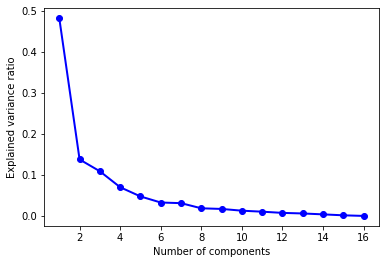

In [ ]:
plt.plot(range(1, 17), pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

This graph is called a scree plot it helps determine a good number of components. at around 8-10 the graph levels out suggesting that a number from 8-10 would be a good choice to start with for my PCA n_components. So i started with 10 and gradually increased n_components 15 was what i decided to go with as the model was capturing most of the relevant data at this number.

In [ ]:
n_components = np.argmax(cumulative_explained_variance >= 0.999) + 1

print(f"Number of components capturing 99.9% of the variance: {n_components}")

Number of components capturing 99.9% of the variance: 15


In [ ]:
pca = PCA(n_components=15)
pca.fit(X_train_flat)

X_transformed = pca.transform(X_train_flat)
X_valid_transformed = pca.transform(X_valid_flat)
X_test_transformed = pca.transform(X_test_flat)

In [ ]:
X_transformed = np.reshape(X_transformed, (X_train.shape[0], X_train.shape[1], -1))
X_valid_transformed = np.reshape(X_valid_transformed, (X_valid.shape[0], X_valid.shape[1], -1))
X_test_transformed = np.reshape(X_test_transformed, (X_test.shape[0], X_test.shape[1], -1))

In [ ]:
X_transformed.shape, X_valid_transformed.shape, X_test_transformed.shape

((222475, 5, 15), (65520, 5, 15), (94161, 5, 15))

In [ ]:
X_train.shape, X_valid.shape, X_test.shape

((222475, 5, 16), (65520, 5, 16), (94161, 5, 16))

In [ ]:
import tensorflow as tf

def my_generator():
    for i in range(len(X_transformed)):
        yield X_transformed[i], y_train[i]


dataset = tf.data.Dataset.from_generator(
    lambda: my_generator(),
    output_types=(tf.float32, tf.float32),
    output_shapes=((SEQUENCE_LEN, X_transformed.shape[2]), (NUM_CLASSES,))  # was messing around with this correct function below
)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size)



In [ ]:
def create_dataset(X, y, shuffle=True, cache=True):
    """
    Creates a TensorFlow dataset from the given input and target. As i couldn't get TF slices method of batching data
    to work.

    Args:
        X (np.ndarray): Input array of windowed data with shape (num_samples, sequence_length, num_features).
        y (np.ndarray): Target array with shape (num_samples, num_classes).
        shuffle (bool, optional): Whether to shuffle the data. Defaults to True.
        cache (bool, optional): Whether to cache the dataset in memory. Defaults to True.

    Returns:
        tf.data.Dataset: A TF dataset object containing the input and target data.
    """
    def my_generator():
        for i in range(len(X)):
            yield X[i], y[i]

    dataset = tf.data.Dataset.from_generator(
        lambda: my_generator(),
        output_types=(tf.float32, tf.float32),
        output_shapes=((SEQUENCE_LEN, X.shape[2]), (NUM_CLASSES,))
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    if cache:
        dataset = dataset.cache()

    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_ds_pca = create_dataset(X_transformed, y_train)
valid_ds_pca = create_dataset(X_valid_transformed, y_valid) #create batched datasets for pca data
test_ds_pca = create_dataset(X_test_transformed, y_test)

In [ ]:
train_ds_pca

<BatchDataset element_spec=(TensorSpec(shape=(None, 5, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 5, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], -1))  #reshape data so its suitable for RF
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [ ]:
X_train.shape, y_train.shape #check shapes see if its compatable for rf

((222475, 80), (222475, 4))

# Quick data check

In [ ]:
def calculate_class_counts(data, num_classes):
    """
    Calculates number of samples for each class in dataset

    Parameters:
        data (tf.data.Dataset) - A batched dataset
        num_classes (int): number of classes in the dataset.

    Returns:
        The function prints the number of samples for each class.
    """
    class_counts = np.zeros(num_classes)
    for x, y in data:
        y = tf.argmax(y, axis=1)
        class_counts += np.bincount(y, minlength=num_classes)
    return print(f"this data has this many classes: {class_counts}")

In [ ]:
calculate_class_counts(train_ds, NUM_CLASSES)

this data has this many classes: [80159. 52977. 54089. 35250.]


In [ ]:
calculate_class_counts(train_ds_pca, NUM_CLASSES)

this data has this many classes: [80159. 52977. 54089. 35250.]


# Base_model LSTM with no PCA

In [ ]:
tf.random.set_seed(42) # set seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [ ]:
lstm_base = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(SEQUENCE_LEN, NUM_COLS)),
    LSTM(units=32),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
lstm_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = lstm_base.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
1739/1739 [==============================] - 14s 6ms/step - loss: 0.4703 - accuracy: 0.8019 - val_loss: 0.4381 - val_accuracy: 0.8161
Epoch 2/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3993 - accuracy: 0.8333 - val_loss: 0.4184 - val_accuracy: 0.8262
Epoch 3/10
1739/1739 [==============================] - 10s 6ms/step - loss: 0.3843 - accuracy: 0.8397 - val_loss: 0.4075 - val_accuracy: 0.8308
Epoch 4/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3735 - accuracy: 0.8451 - val_loss: 0.4036 - val_accuracy: 0.8327
Epoch 5/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3645 - accuracy: 0.8490 - val_loss: 0.4018 - val_accuracy: 0.8339
Epoch 6/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3563 - accuracy: 0.8527 - val_loss: 0.3979 - val_accuracy: 0.8349
Epoch 7/10
1739/1739 [==============================] - 10s 6ms/step - loss: 0.3487 - accuracy: 0.8559 - val_loss: 0.3975 - val_accura

In [ ]:
# cache results
lstm_base.save('lstm_base.h5')

with open('lstm_base.json', 'w') as f:
        json.dump(history.history, f)

In [ ]:
lstm_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             20736     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 35,524
Trainable params: 35,524
Non-trainable params: 0
_________________________________________________________________


# LSTM performance investigation 1: PCA

In [ ]:
lstm_pca = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(SEQUENCE_LEN, 15)),
    LSTM(units=32),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
lstm_pca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = lstm_pca.fit(train_ds_pca, validation_data=valid_ds_pca, epochs=10)

Epoch 1/10
1739/1739 [==============================] - 18s 9ms/step - loss: 0.4365 - accuracy: 0.8173 - val_loss: 0.4638 - val_accuracy: 0.8161
Epoch 2/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3707 - accuracy: 0.8459 - val_loss: 0.4328 - val_accuracy: 0.8271
Epoch 3/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3555 - accuracy: 0.8529 - val_loss: 0.4083 - val_accuracy: 0.8348
Epoch 4/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3443 - accuracy: 0.8579 - val_loss: 0.3926 - val_accuracy: 0.8401
Epoch 5/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3357 - accuracy: 0.8619 - val_loss: 0.3850 - val_accuracy: 0.8424
Epoch 6/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3282 - accuracy: 0.8655 - val_loss: 0.3809 - val_accuracy: 0.8441
Epoch 7/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3212 - accuracy: 0.8684 - val_loss: 0.3790 - val_accuracy

In [ ]:
# cache results
lstm_pca.save('lstm_pca.h5')

with open('lstm_pca.json', 'w') as f:
        json.dump(history.history, f)

In [ ]:
lstm_pca.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 64)             20480     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 35,268
Trainable params: 35,268
Non-trainable params: 0
_________________________________________________________________


# LSTM  - performance investigation 2: Deeper model

In [ ]:
lstm_deep = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(SEQUENCE_LEN, NUM_COLS)),
    Dropout(0.2),
    LSTM(units=32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
lstm_deep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = lstm_deep.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
1739/1739 [==============================] - 13s 6ms/step - loss: 0.5210 - accuracy: 0.7809 - val_loss: 0.4466 - val_accuracy: 0.8129
Epoch 2/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.4285 - accuracy: 0.8225 - val_loss: 0.4282 - val_accuracy: 0.8243
Epoch 3/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.4122 - accuracy: 0.8298 - val_loss: 0.4129 - val_accuracy: 0.8333
Epoch 4/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.4004 - accuracy: 0.8356 - val_loss: 0.4071 - val_accuracy: 0.8346
Epoch 5/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3928 - accuracy: 0.8387 - val_loss: 0.4042 - val_accuracy: 0.8362
Epoch 6/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3857 - accuracy: 0.8422 - val_loss: 0.4001 - val_accuracy: 0.8362
Epoch 7/10
1739/1739 [==============================] - 9s 5ms/step - loss: 0.3780 - accuracy: 0.8448 - val_loss: 0.4042 - val_accuracy

In [ ]:
# cache results
lstm_deep.save('lstm_deep.h5')

with open('lstm_deep.json', 'w') as f:
        json.dump(history.history, f)

In [ ]:
lstm_deep.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 64)             20736     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)              

# Random Forest plain


In [ ]:
rfp = RandomForestClassifier(n_estimators=100)
rfp.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
joblib.dump(rfp, 'rfp_model.joblib') # save model

['rfp_model.joblib']

# Random Forest - Performance investigation 3: changed hyper parameters


In [ ]:
rfh = RandomForestClassifier(n_estimators=300, max_depth=25) #n_estiamtors and max depth changed
rfh.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, n_estimators=300)

In [ ]:
joblib.dump(rfh, 'rfh_model.joblib') # save model

['rfh_model.joblib']

# Final model on the test data PCA + DEEP + hyper param combined

In [ ]:
lstm_final = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(SEQUENCE_LEN, 15)),
    Dropout(0.2),
    LSTM(units=32),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])


In [ ]:
lstm_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = lstm_final.fit(train_ds_pca, validation_data=test_ds_pca, epochs=20)

Epoch 1/20
1739/1739 [==============================] - 22s 11ms/step - loss: 0.4924 - accuracy: 0.7927 - val_loss: 0.5245 - val_accuracy: 0.8016
Epoch 2/20
1739/1739 [==============================] - 10s 6ms/step - loss: 0.4103 - accuracy: 0.8306 - val_loss: 0.4748 - val_accuracy: 0.8172
Epoch 3/20
1739/1739 [==============================] - 10s 6ms/step - loss: 0.3939 - accuracy: 0.8381 - val_loss: 0.4421 - val_accuracy: 0.8254
Epoch 4/20
1739/1739 [==============================] - 10s 6ms/step - loss: 0.3843 - accuracy: 0.8423 - val_loss: 0.4409 - val_accuracy: 0.8289
Epoch 5/20
1739/1739 [==============================] - 10s 6ms/step - loss: 0.3748 - accuracy: 0.8469 - val_loss: 0.4307 - val_accuracy: 0.8327
Epoch 6/20
1739/1739 [==============================] - 10s 6ms/step - loss: 0.3673 - accuracy: 0.8495 - val_loss: 0.4236 - val_accuracy: 0.8358
Epoch 7/20
1739/1739 [==============================] - 10s 6ms/step - loss: 0.3614 - accuracy: 0.8526 - val_loss: 0.4192 - val_a

In [ ]:
lstm_final.save('lstm_final.h5')

with open('lstm_final.json', 'w') as f:
        json.dump(history.history, f)

In [ ]:
lstm_final.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 64)             20480     
                                                                 
 dropout_8 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 128)              